In [29]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm

from numpy import NaN, NAN, nan
import shap 

In [30]:
model = torch.jit.load('model_scripted.pt')

In [31]:
data = pd.read_csv("Gen_History_data.csv", index_col=0)
features = data.drop(columns=["Time","generation"])
target = data["generation"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# SHAP Calculation
def model_func(data):
    model.eval()  # ensure the model is in evaluation mode
    data_tensor = torch.from_numpy(data.astype(np.float32))  # convert the numpy array to a torch tensor
    with torch.no_grad():  # turn off gradients for prediction
        output = model(data_tensor)
    return output.cpu().numpy()  # assuming you're using a GPU

background_data = X_test
test_data = X_test


explainer = shap.KernelExplainer(model_func, shap.kmeans(background_data, 10))
SHAP_values = explainer.shap_values(test_data)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/4493 [00:00<?, ?it/s]

In [40]:
SHAP_data = pd.DataFrame(SHAP_values[0])
SHAP_data.to_csv("SHAP_Result.csv")
SHAP_data

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,397.775893,-56.692285,-65.551257,109.135714,-241.634206,-26.433879,-54.178587,-569.563588,408.080751,-72.174634,...,373.527913,-129.677720,0.000000,-221.152366,2181.336668,-653.354603,-157.588020,-403.604728,482.581029,-141.813376
1,237.254045,0.000000,-115.018524,-138.501399,201.895219,47.724322,-43.499882,395.785796,-598.708066,273.645543,...,161.598899,-226.524012,-133.805886,625.192583,2638.414489,-1006.734725,-104.902687,-91.252023,256.102108,141.835821
2,-189.269182,46.905800,-422.455486,224.060781,76.725892,-212.800920,-142.292970,106.366172,40.021402,-150.383325,...,21.573663,167.997498,251.501153,2890.799140,-686.272522,683.966594,23.730824,921.261512,-843.885128,1408.739577
3,-232.304144,-143.321743,423.448044,158.485153,77.550450,-196.799711,-76.447469,-784.849413,399.838769,191.378655,...,124.317201,-48.905350,-430.865496,3973.717712,-1270.256084,649.054360,-90.598991,761.563657,1762.155533,408.739396
4,193.686712,60.616353,-60.762337,408.960896,182.789900,419.272155,-228.074655,-190.781941,-176.046468,-248.345508,...,-90.697090,113.391322,37.856726,3076.599101,-1031.520295,545.308068,-157.358153,135.627238,-843.067220,1007.135182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4488,-1441.652019,-128.459176,-497.177820,-311.475868,-555.703347,443.727383,-43.744466,337.235054,299.764440,152.029473,...,-190.663878,-96.775861,656.442080,7950.379161,-1319.759959,-131.624128,408.037972,-3253.667743,2494.109059,199.111293
4489,853.495837,-154.909131,0.000000,-186.996599,0.000000,1412.972869,0.000000,0.000000,-217.082994,0.000000,...,-402.769539,249.280755,-552.769245,6608.486336,-4779.266249,4881.870369,0.000000,923.534037,4334.078279,-2404.696063
4490,-86.343880,-291.026723,-56.911327,410.428651,-164.917468,0.000000,0.000000,-609.812951,-90.872405,0.000000,...,-159.758517,-105.653384,497.033080,-11073.946183,672.982376,-518.868280,-897.369017,1485.746344,-1604.850516,0.000000
4491,-2044.669580,132.686600,545.871420,-1207.891514,134.334438,-1202.838257,-49.369566,72.485395,-750.641372,0.000000,...,252.894582,-683.854233,100.630433,2706.568467,-1115.238777,1130.741278,2619.841101,-1972.429050,-1393.034405,-2701.778583


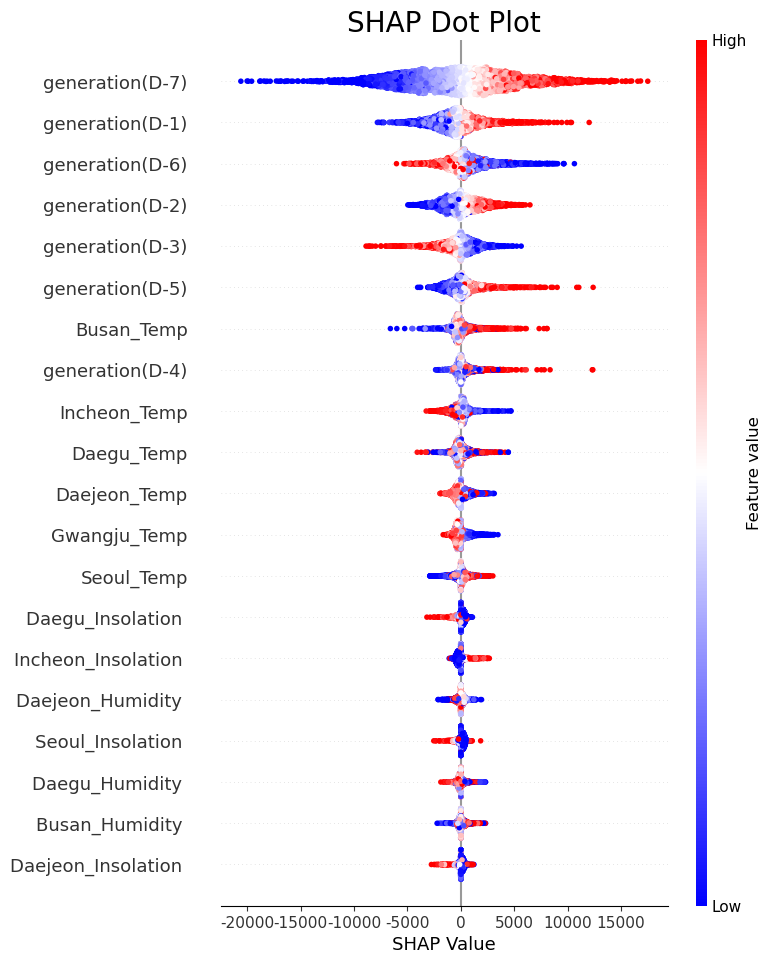

In [41]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(SHAP_values[0], background_data, 
                  feature_names=features.columns, ## 변수명 표시
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()

가장 교호작용이 큰 것이 색으로 나타남

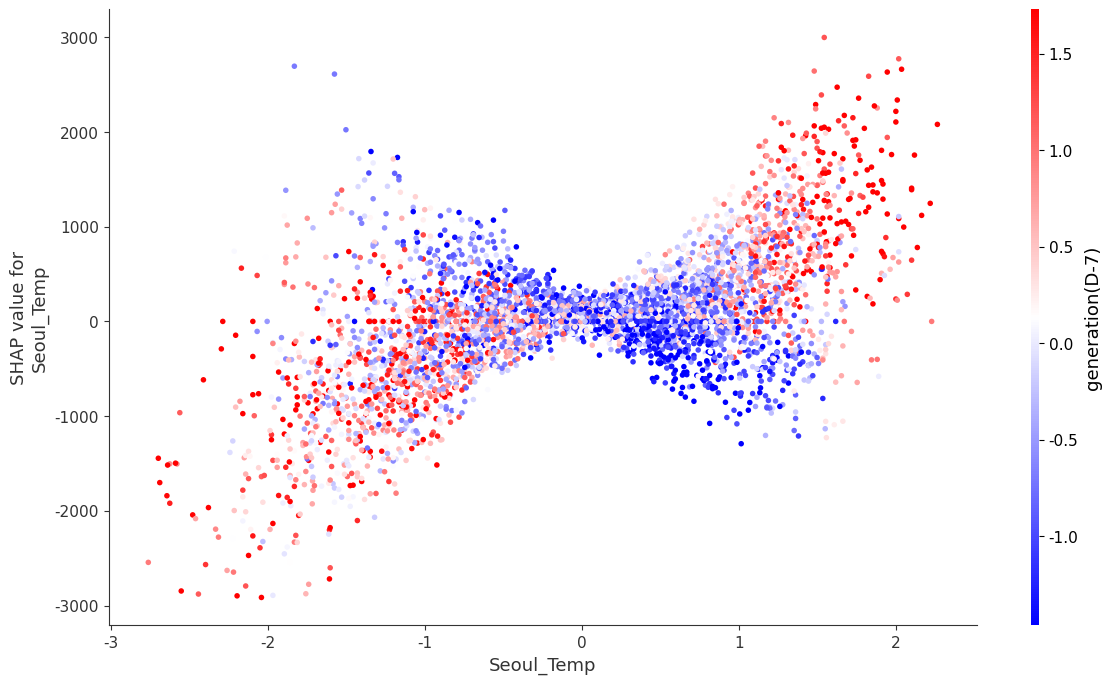

In [44]:
## Bar Plot
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
 
fig = plt.figure(figsize=(14,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.dependence_plot(15, SHAP_values[0], background_data,
                  feature_names=features.columns, ## 변수명 표시
                  ax = ax, ## 현재 좌표축
                  cmap = 'bwr' ## 컬러맵
                 )
 
ax.set_title('SHAP Dependence Plot', fontsize=20)
plt.show()